## 1) Setup + Load Data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
import seaborn as sns
from pathlib import Path

# Deine Module
from src.datasets.dataloaders import get_pcam_dataloaders
from src.models.small_cnn import SmallCNN
from src.models.resnet_pcam import ResNetPCam, ResNetConfig

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Test-Daten laden (nur Test!)
loaders = get_pcam_dataloaders(
    data_root="data/raw",
    batch_size=64,
    center_crop_size=64,
    num_workers=0
)
test_loader = loaders["test"]

In [2]:
print(device)

cuda


## 2) Helper Functions

In [3]:
def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_scores = [] # Wahrscheinlichkeiten (0.0 bis 1.0)
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Modell Output holen
            logits = model(images)
            probs = torch.sigmoid(logits) # Logits -> Wahrscheinlichkeit
            
            y_true.extend(labels.numpy())
            y_scores.extend(probs.cpu().numpy())
            
    return np.array(y_true), np.array(y_scores)

## 3) Load Models

In [9]:
# A. Small CNN
cnn_model = SmallCNN(dropout_p=0.5).to(device)
cnn_model.load_state_dict(torch.load("experiments/final_models/small_cnn_final_baseline_best.pth"))
y_true, scores_cnn = get_predictions(cnn_model, test_loader)

# B. ResNet Frozen
cfg_frozen = ResNetConfig(tl_mode="frozen", pretrained=True)
resnet_frozen = ResNetPCam(cfg_frozen).to(device)
resnet_frozen.load_state_dict(torch.load("experiments/final_models/resnet_frozen_final_best.pth"))
_, scores_frozen = get_predictions(resnet_frozen, test_loader) # y_true ist gleich

# C. ResNet Partial
cfg_partial = ResNetConfig(tl_mode="partial", pretrained=True)
resnet_partial = ResNetPCam(cfg_partial).to(device)
resnet_partial.load_state_dict(torch.load("experiments/final_models/resnet_partial_final_best.pth"))
_, scores_partial = get_predictions(resnet_partial, test_loader)

## 4) Plot 1: ROC Comparison

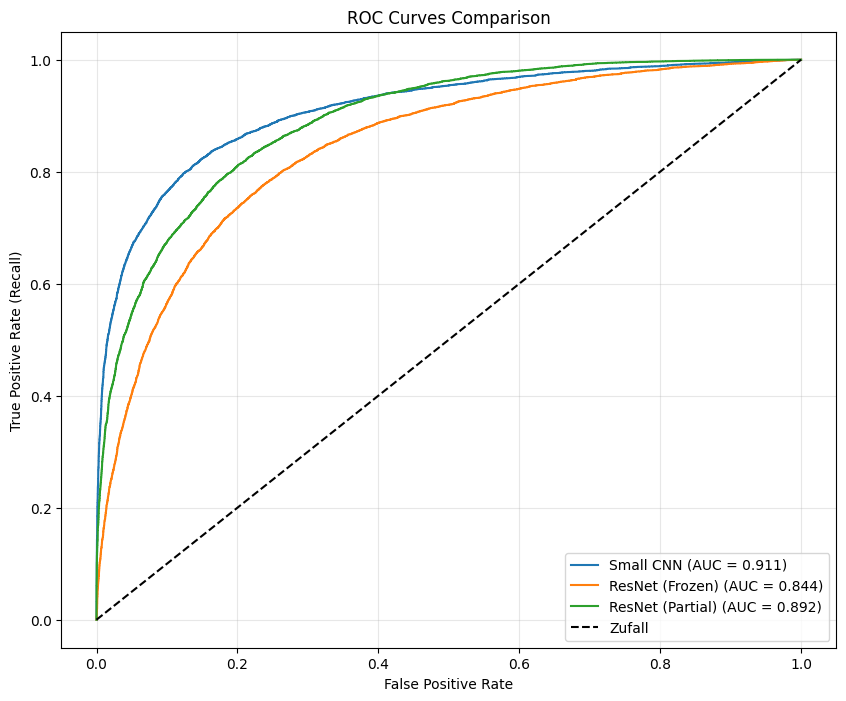

In [10]:
plt.figure(figsize=(10, 8))

# Dictionary für einfache Schleife
results = {
    "Small CNN": scores_cnn,
    "ResNet (Frozen)": scores_frozen,
    "ResNet (Partial)": scores_partial
}

for name, scores in results.items():
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Zufall')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 5) Plot 2: Precision-Recall 

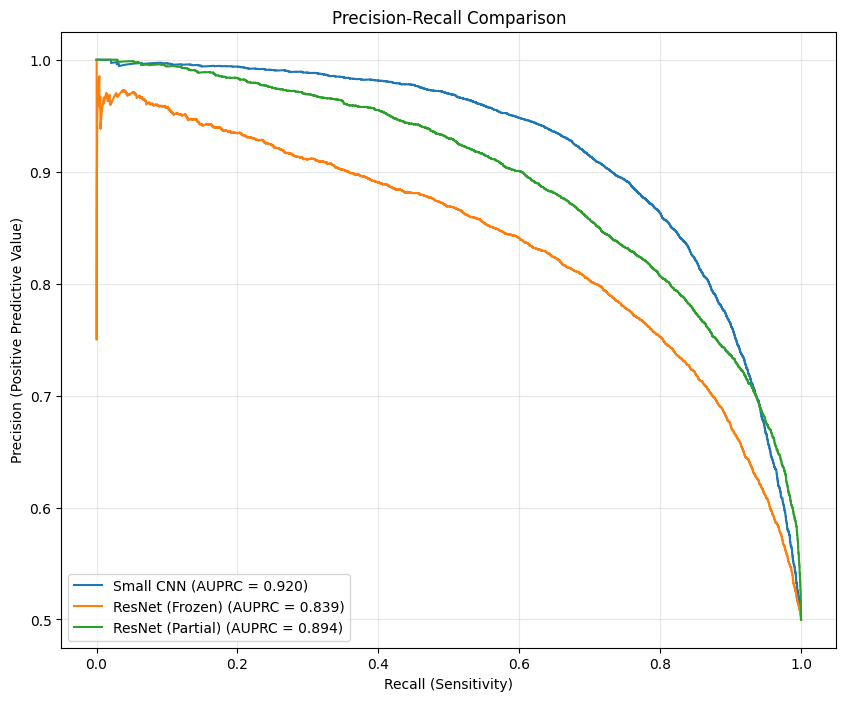

In [11]:
plt.figure(figsize=(10, 8))

for name, scores in results.items():
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUPRC = {pr_auc:.3f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Comparison')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

## 6) Table for Paper

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

data = []
threshold = 0.5 # Standard-Grenzwert

for name, scores in results.items():
    preds = (scores >= threshold).astype(int)
    
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    roc_auc = roc_auc_score(y_true, scores)
    pr_auc = average_precision_score(y_true, scores)
    
    data.append({
        "Model": name,
        "AUROC": roc_auc,
        "AUPRC": pr_auc,
        "F1-Score": f1,
        "Accuracy": acc
    })

df = pd.DataFrame(data)
print(df)
df.to_csv("experiments/results_simple_comparison.csv")

              Model     AUROC     AUPRC  F1-Score  Accuracy
0         Small CNN  0.910798  0.920313  0.792035  0.816742
1   ResNet (Frozen)  0.844340  0.838919  0.764252  0.768555
2  ResNet (Partial)  0.892369  0.893596  0.754062  0.784271
